In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

algorithm_globals.random_seed = 42

In [2]:
sampler1 = Sampler()

sampler2 = Sampler()

In [3]:
num_samples = 40
num_features = 2
features = 2 * algorithm_globals.random.random([num_samples, num_features]) - 1
labels = 1 * (np.sum(features, axis=1) >= 0)  # in { 0,  1}

In [4]:
features = MinMaxScaler().fit_transform(features)
features.shape

(40, 2)

In [5]:
features[0:5, :]

array([[0.79067335, 0.44566143],
       [0.88072937, 0.7126244 ],
       [0.06741233, 1.        ],
       [0.7770372 , 0.80422817],
       [0.10351936, 0.45754615]])

In [6]:
labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))
labels.shape

(40, 2)

In [7]:
labels[0:5, :]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=30, random_state=algorithm_globals.random_seed
)
train_features.shape

(30, 2)

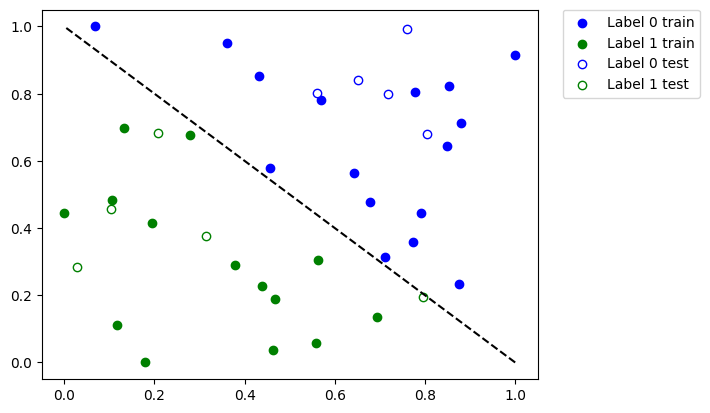

In [9]:

def plot_dataset():
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 0), 0],
        train_features[np.where(train_labels[:, 0] == 0), 1],
        marker="o",
        color="b",
        label="Label 0 train",
    )
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 1), 0],
        train_features[np.where(train_labels[:, 0] == 1), 1],
        marker="o",
        color="g",
        label="Label 1 train",
    )

    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 0), 0],
        test_features[np.where(test_labels[:, 0] == 0), 1],
        marker="o",
        facecolors="w",
        edgecolors="b",
        label="Label 0 test",
    )
    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 1), 0],
        test_features[np.where(test_labels[:, 0] == 1), 1],
        marker="o",
        facecolors="w",
        edgecolors="g",
        label="Label 1 test",
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.plot([1, 0], [0, 1], "--", color="black")


plot_dataset()
plt.show()

In [10]:
maxiter = 100

In [13]:
objective_values = []

In [14]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")

    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]

    stage2_len = np.max((0, len(objective_values) - maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len - 1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]

    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()


plt.rcParams["figure.figsize"] = (12, 6)

In [15]:
original_optimizer = COBYLA(maxiter=maxiter)

ansatz = RealAmplitudes(num_features)
initial_point = np.asarray([0.5] * ansatz.num_parameters)

In [16]:
original_classifier = VQC(
    ansatz=ansatz, optimizer=original_optimizer, callback=callback_graph, sampler=sampler1
)

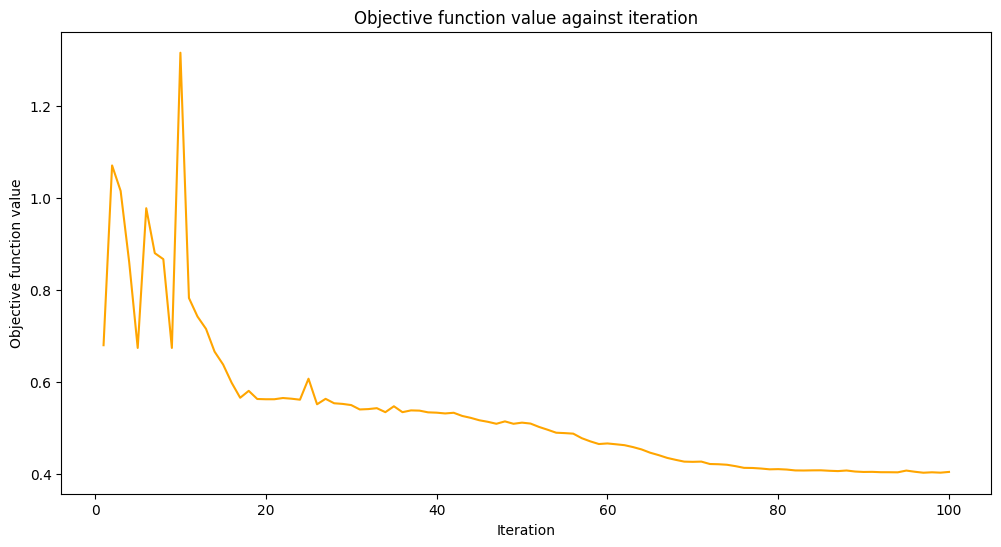

In [17]:
original_classifier.fit(train_features, train_labels)

In [18]:
print("Train score", original_classifier.score(train_features, train_labels))
print("Test score ", original_classifier.score(test_features, test_labels))

Train score 0.8666666666666667
Test score  0.8


In [19]:
original_classifier.save("vqc_classifier.model")

In [20]:
loaded_classifier = VQC.load("vqc_classifier.model")

In [21]:
loaded_classifier.warm_start = True
loaded_classifier.neural_network.sampler = sampler2
loaded_classifier.optimizer = COBYLA(maxiter=180)

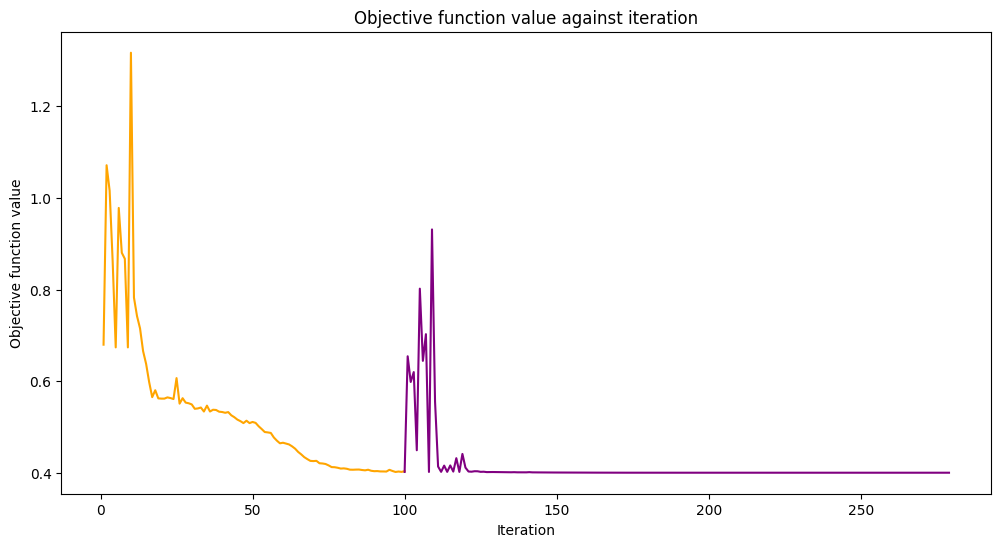

In [22]:
loaded_classifier.fit(train_features, train_labels)

In [23]:
print("Train score", loaded_classifier.score(train_features, train_labels))
print("Test score", loaded_classifier.score(test_features, test_labels))

Train score 0.8666666666666667
Test score 0.8


In [24]:
train_predicts = loaded_classifier.predict(train_features)
test_predicts = loaded_classifier.predict(test_features)

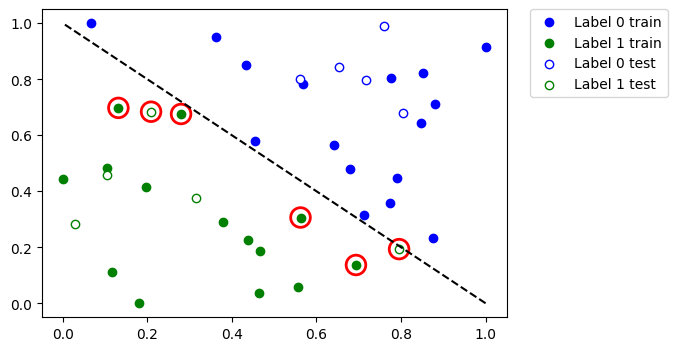

In [25]:

# return plot to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

plot_dataset()

# plot misclassified data points
plt.scatter(
    train_features[np.all(train_labels != train_predicts, axis=1), 0],
    train_features[np.all(train_labels != train_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)
plt.scatter(
    test_features[np.all(test_labels != test_predicts, axis=1), 0],
    test_features[np.all(test_labels != test_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)